<a href="https://colab.research.google.com/github/daspartho/learn-pytorch/blob/main/datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)
print("Done!")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping data...
Done!


In [4]:
import os

def walk_dir(dir):
    for dirpath, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/train/sushi/2323548.jpg
Image class: sushi
Image height: 512
Image eidth: 512


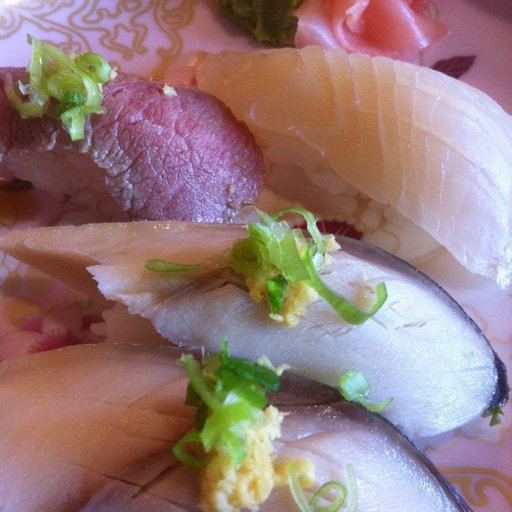

In [6]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

rand_image_path = random.choice(image_path_list)

image_class = rand_image_path.parent.stem

img= Image.open(rand_image_path)

print(f"Image path: {rand_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image eidth: {img.width}")
img

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

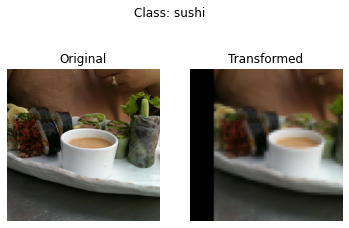

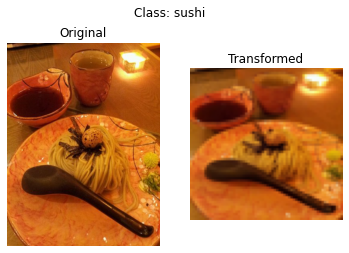

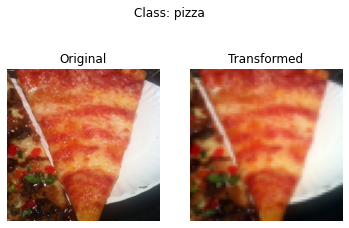

In [9]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3):

    random_image_paths = random.sample(image_paths, k=n)

    for image_path  in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title("Original")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title("Transformed")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_path_list, data_transform)

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [11]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [12]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image label: {label}")

Image shape: torch.Size([3, 64, 64])
Image label: 0


Permuted image shape: torch.Size([64, 64, 3])


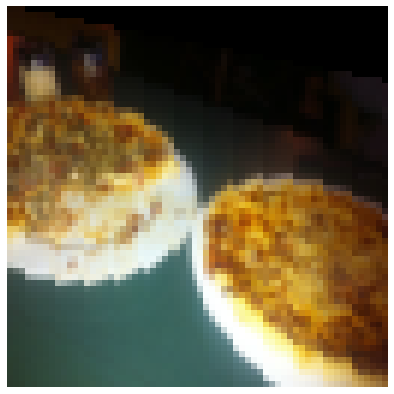

In [13]:
img_permute = img.permute(1,2,0)

print(f"Permuted image shape: {img_permute.shape}")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False);

In [14]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=16,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [15]:
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [16]:
target_directory = train_dir

class_names = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

['pizza', 'steak', 'sushi']

In [17]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")

    class_to_idx = {name: i for i, name in enumerate(classes)}

    return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [18]:
class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None) -> None:

        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, idx: int) -> Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [19]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [20]:
train_data = ImageFolderCustom(train_dir, train_transforms)
test_data = ImageFolderCustom(test_dir, test_transforms)

In [21]:
len(train_data)

225

In [22]:
train_data.classes

['pizza', 'steak', 'sushi']

In [23]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

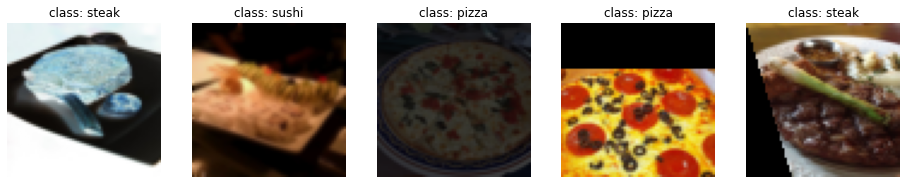

In [24]:
def display_random_images(
    dataset: torch.utils.data.Dataset,
    n: int = 5,
    seed: int = None,
):

    if seed: 
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, sample_idx in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[sample_idx]

        targ_image_permute = targ_image.permute(1,2,0)

        plt.subplot(1,n, i+1)
        plt.imshow(targ_image_permute)
        plt.axis(False)

        plt.title(f"class: {dataset.classes[targ_label]}")

display_random_images(train_data)

In [25]:
train_dataloader = DataLoader(train_data, 
                              batch_size=1,
                              shuffle=True)

test_dataloader = DataLoader(test_data, 
                              batch_size=1,
                              shuffle=False)

img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))